In [1]:
import keras
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from pennylane import AngleEmbedding, StronglyEntanglingLayers
import pennylane as qml
import os
import tensorflow as tf

2024-01-07 09:03:06.057458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 09:03:06.057513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 09:03:06.091414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 09:03:06.171487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 09:03:07.118744: W tensorflow/compiler/tf2

In [2]:
num_qubits = 2

In [3]:
X, y = datasets.make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)

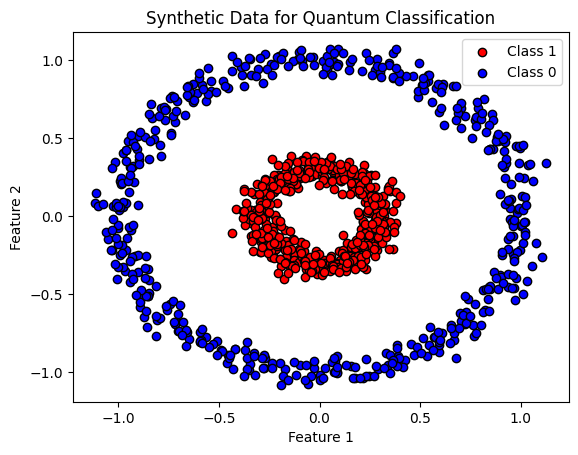

In [4]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='r', marker='o', edgecolors='k', label="Class 1")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='b', marker='o', edgecolors='k', label="Class 0")
plt.title("Synthetic Data for Quantum Classification")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [5]:
device = qml.device("default.qubit.tf", wires=2)

@qml.qnode(device, interface="tf")
def layer(weights, inputs):
    
    AngleEmbedding(inputs, wires=range(2))
    
    StronglyEntanglingLayers(weights, wires=range(2))
    
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

2024-01-07 09:03:10.017361: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 09:03:10.223032: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 09:03:10.223098: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 09:03:10.225406: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-07 09:03:10.225456: I external/local_xla/xla/stream_executor

In [6]:
num_layers = 1
epochs = 30

In [7]:
qlayer = qml.qnn.KerasLayer(layer, {"weights": (num_layers, num_qubits, 3)}, output_dim=num_qubits)
qlayer.trainable = True

In [8]:
model = keras.Sequential([
    keras.layers.Dense(2, activation=None),
    qlayer,
    keras.layers.Dense(2, activation='softmax')
])

In [9]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [10]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9)
model.compile(optimizer, loss=loss_fn, metrics=metrics)

In [11]:
fitting = model.fit(X, y, epochs=epochs, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/30


2024-01-07 09:03:11.162065: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2024-01-07 09:03:12.373069: I external/local_xla/xla/service/service.cc:168] XLA service 0x1490c9a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-07 09:03:12.373112: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-01-07 09:03:12.394518: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1704614592.438858    1097 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 4s 94ms/step - loss: 0.6809 - sparse_categorical_accuracy: 0.5038 - val_loss: 0.6775 - val_sparse_categorical_accuracy: 0.5450
Epoch 2/30
25/25 [==============================] - 2s 91ms/step - loss: 0.6742 - sparse_categorical_accuracy: 0.5888 - val_loss: 0.6728 - val_sparse_categorical_accuracy: 0.6050
Epoch 3/30
25/25 [==============================] - 2s 95ms/step - loss: 0.6695 - sparse_categorical_accuracy: 0.6775 - val_loss: 0.6671 - val_sparse_categorical_accuracy: 0.6850
Epoch 4/30
25/25 [==============================] - 2s 97ms/step - loss: 0.6639 - sparse_categorical_accuracy: 0.7937 - val_loss: 0.6600 - val_sparse_categorical_accuracy: 0.7650
Epoch 5/30
25/25 [==============================] - 2s 96ms/step - loss: 0.6550 - sparse_categorical_accuracy: 0.7350 - val_loss: 0.6505 - val_sparse_categorical_accuracy: 0.7400
Epoch 6/30
25/25 [==============================] - 2s 95ms/step - loss: 0.6438 - sparse_categorical_accuracy: 0.743

In [12]:
model.evaluate(X, y, batch_size=64)

16/16 [==============================] - 1s 35ms/step - loss: 0.0708 - sparse_categorical_accuracy: 1.0000


[0.07084223628044128, 1.0]

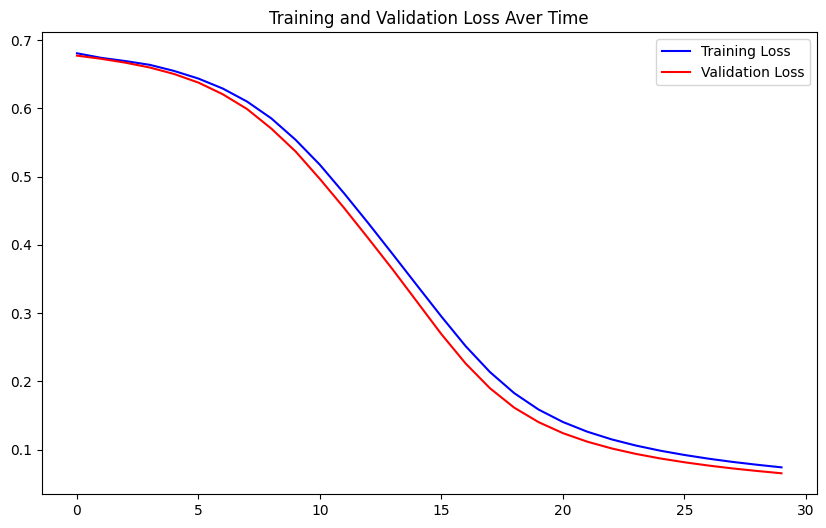

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(fitting.history['loss']), "-b", label="Training Loss")
plt.plot(np.array(fitting.history['val_loss']), "-r", label="Validation Loss")
plt.title("Training and Validation Loss Aver Time")
plt.legend()
plt.show()

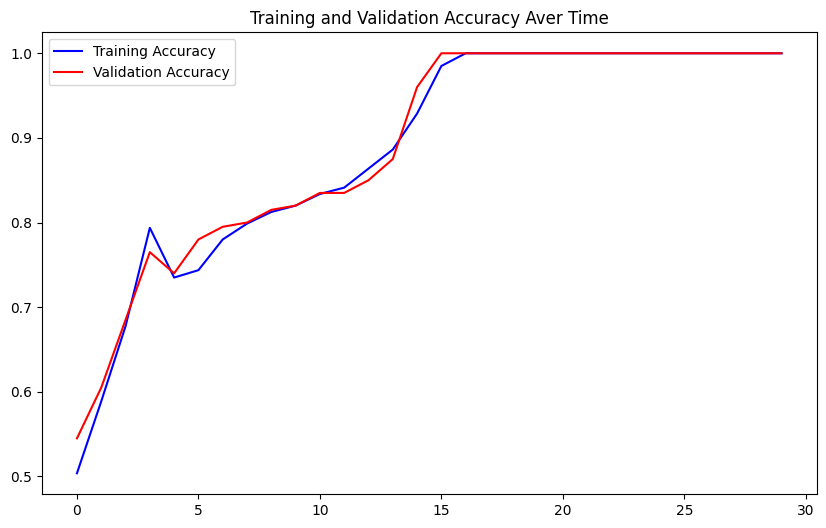

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(fitting.history['sparse_categorical_accuracy']), "-b", label="Training Accuracy")
plt.plot(np.array(fitting.history['val_sparse_categorical_accuracy']), "-r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy Aver Time")
plt.legend()
plt.show()